In [1]:
%matplotlib inline
import numpy as np
from numpy.random import uniform
import igraph 
from time import time
import mpl_toolkits.mplot3d as a3
import matplotlib.pyplot as plt

In [6]:
from packtets.geometry import Tet
from packtets.graph import packing_graph
from packtets.graph import greedy_max
from packtets.graph import exact_igraph
N = 20
L = 1
vx = np.array([L,0,0])
vy = np.array([0,L,0])
vz = np.array([0,0,L])
tets = []
t0 = time()
for i in range(N):
    center = uniform(0, L, 3)
    theta = uniform(0, 2*np.pi)
    phi = uniform(0, 2*np.pi)
    psi = uniform(9, 2*np.pi)
    tets.append(Tet(center, theta, phi, psi))
print(">> Took {:7.4f}s to make Tets".format(time()-t0))

t0 = time()
g = packing_graph(tets, vx, vy, vz)
print(">> Took {:7.4f}s to make graph".format(time()-t0))

t0 = time()
num_packed = greedy_max(g)
packing_ratio = num_packed / (6*np.sqrt(2)) / L**3
print(L, num_packed, packing_ratio)
print(">> Took {:7.4f}s for greedy algorithm".format(time()-t0))

t0 = time()
max_ind_set = exact_igraph(g)
num_packed = len(max_ind_set)
packing_ratio = num_packed / (6*np.sqrt(2)) / L**3
print(L, num_packed, packing_ratio)
print(">> Took {:7.4f}s to compute independence number".format(time()-t0))

>> Took  0.0018s to make Tets
>> Took  2.0792s to make graph
1 2 0.235702260396
>> Took  0.0014s for greedy algorithm
1 2 0.235702260396
>> Took  0.0005s to compute independence number


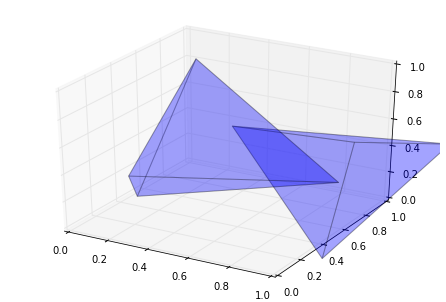

In [5]:
import scipy as sp
ax = a3.Axes3D(plt.figure(10))
for i in max_ind_set:
    for x,y,z in [(0,1,2), (0,1,3), (0,2,3), (1,2,3)]:
        verts = [tuple(tets[i].verts[x]), tuple(tets[i].verts[y]), tuple(tets[i].verts[z])]
        tri = a3.art3d.Poly3DCollection([verts], alpha=0.2)
        tri.set_edgecolor('k')
        ax.add_collection3d(tri)
ax.set_xlim(0,L)
ax.set_ylim(0,L)
ax.set_zlim(0,L)
plt.show()